In [1]:
%load_ext autoreload  
%autoreload 2 
%matplotlib inline

In [2]:
import octopus
from src import *

import numpy as np
import pandas as pd
import timm
from sklearn import metrics
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations
from transformers import AdamW
import matplotlib.pyplot as plt


In [3]:
class Config: 
    debug = True
    epochs = 5
    batch_size = 4
    image_size = 256

In [4]:
data_path = "./data"
df_train = pd.read_csv(f'{data_path}/train.csv')
if Config.debug: 
    df_train = df_train[:8]
train_img_paths = [f"{data_path}/train/{id}.jpg" for id in df_train["Id"].values]

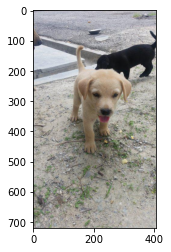

In [5]:
image = cv2.imread(train_img_paths[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [22]:
train_aug = albumentations.Compose(
    [
        albumentations.Resize(Config.image_size, Config.image_size, p=1),
        albumentations.HueSaturationValue(
            hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5
        ),
        albumentations.RandomBrightnessContrast(
            brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5
        ),
        albumentations.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0,
        ),
    ],
    p=1.0,
)
dense_features = [
    'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
    'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'
]

train_ds = PawpularDataset(
    image_paths=train_img_paths,
    dense_features=df_train[dense_features].values,
    targets=df_train.Pawpularity.values,
    augmentation=train_aug
)

In [23]:
train_dl = DataLoader(train_ds, batch_size=Config.batch_size, shuffle=False)

In [24]:
len(train_dl)

2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


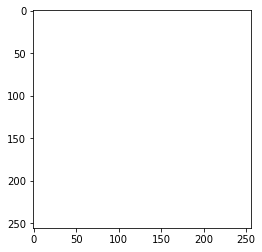

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


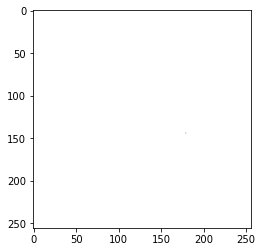

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


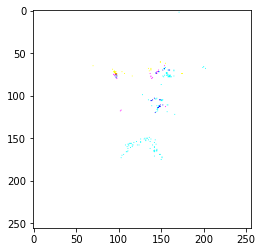

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


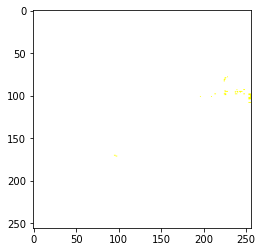

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


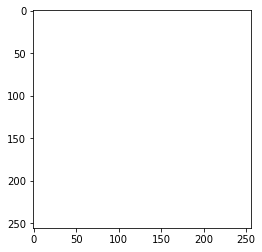

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


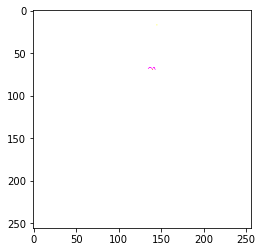

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


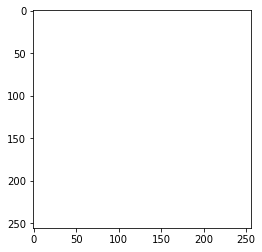

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


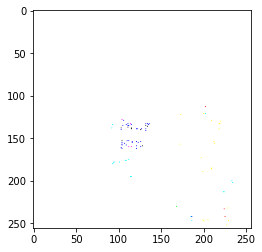

In [25]:
for batch_x, batch_y in train_dl:
    # print(f"batch_x: {batch_x['image'].dtype}, {batch_x['image'].shape} | batch_y: {batch_y.shape}")
    for img in batch_x['image']:
        img = img.numpy()
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.show()

In [24]:
model.model

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
 

In [9]:
# classifier = timm.create_model("tf_efficientnet_b0_ns", pretrained=True, in_chans=3).classifier; print(classifier)

In [15]:
from tqdm import tqdm
class Debugger(octopus.Callback):
    def before_train_loss(self):
        tqdm.write(f"self.pred: {self.pred} | self.batch_y: {self.batch_y}")

In [20]:
model = PawpularModel()

cbs = [octopus.ProgressBar(), octopus.TrackLoss(save_model=False, path="./", model_name=f"pawpular"), Debugger()]

epochs = 4
training_steps = len(train_dl) * epochs; print("training steps: ", training_steps)
dls = octopus.DataLoaderGroup(train_dl, train_dl)
# loss_func = nn.MSELoss()
loss_func = octopus.RMSELoss
lr = 1e-4
optimizer = AdamW(model.parameters(), lr = lr)

training steps:  8


In [21]:
learner = octopus.Learner(model, 
                  dls, 
                  loss_func, 
                  optimizer, 
                  lr,  
                  valid_interval=len(train_dl),
                  cbs=cbs)

In [22]:
learner.fit(1)

x shape before cat: torch.Size([4, 128])
feature shape before cat: torch.Size([4, 12])
x shape after cat: torch.Size([4, 140])
self.pred: tensor([[ 0.0484],
        [ 0.0119],
        [-0.0827],
        [-0.0742]], grad_fn=<AddmmBackward>) | self.batch_y: tensor([[63.],
        [42.],
        [28.],
        [15.]])
x shape before cat: torch.Size([4, 128])
feature shape before cat: torch.Size([4, 12])
x shape after cat: torch.Size([4, 140])
x shape before cat: torch.Size([4, 128])
feature shape before cat: torch.Size([4, 12])
x shape after cat: torch.Size([4, 140])
>>>>> best valid loss updated: 48.30895233154297
!!! Warning: model is not saving 
x shape before cat: torch.Size([4, 128])
feature shape before cat: torch.Size([4, 12])
x shape after cat: torch.Size([4, 140])
self.pred: tensor([[0.2438],
        [0.0712],
        [0.0163],
        [0.0636]], grad_fn=<AddmmBackward>) | self.batch_y: tensor([[72.],
        [74.],
        [22.],
        [35.]])
epoch 1: 100%|██████████| 2/2 [00